In [53]:
import pandas as pd
from tqdm import tqdm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [74]:
def prepare_data_volatility(stock, horizon_prev, test_size, window_size):
    stock_copy = stock.copy()
    
    split = int(test_size * stock_copy.shape[0])
    stock_copy = stock_copy.iloc[split - window_size:].copy()
    stock_copy['Date'] = pd.to_datetime(stock_copy['Date'])

    stock_copy.drop(columns=["Volume"], inplace=True)
    
    stock_copy["ret"] = stock_copy['Close'].pct_change()
    stock_copy.dropna(inplace = True)
    
    stock_copy["Volatility"] = stock_copy['ret'].rolling(window=10).std()
    stock_copy.dropna(inplace=True)
    
    stock_copy["Target"] = stock_copy["Volatility"].shift(-horizon_prev)
    stock_copy.dropna(inplace=True)
    
    return stock_copy

In [75]:
class PortfolioPredictionXGBoost_volatility():
    def __init__(self, stock_dict, window_size, test_size, horizon_prev):
        self.stock_dict = stock_dict
        self.window_size = window_size
        self.test_size = test_size
        self.horizon_prev = horizon_prev    
    
    def XG_boost_rolling_window(self, stock: pd.DataFrame):
        
        stock = prepare_data_volatility(stock, self.horizon_prev, self.test_size, self.window_size)
        prediction_dates = []
        predictions = []
  
        features_to_drop = ['Date', 'Target']
        for start in range(0, len(stock) - self.window_size - self.horizon_prev):

            end = start + self.window_size
            train = stock[start:end].copy()
            test = stock[end:end + self.horizon_prev].copy()

            model = XGBRegressor(n_estimators=400,
                                 max_depth=30,
                                 learning_rate=0.01,
                                 verbosity=0)

            model.fit(train.drop(features_to_drop, axis=1), train['Target'])

            pred = model.predict(test.drop(['Date', 'Target'], axis=1))
            predictions.append(pred)
        
            prediction_date = stock.iloc[end + self.horizon_prev - 1]['Date']

            prediction_dates.append(prediction_date)

        predictions = [value[self.horizon_prev-1] for value in predictions]

        df_predictions = pd.DataFrame({'Date': prediction_dates,
                                       'Prediction': predictions})

        predicted_df = stock.merge(df_predictions, on='Date', how='inner')

        return predicted_df
    
    def predict_portfolio(self):
        self.predictions_dic = {}

        for key in tqdm(self.stock_dict):
            self.predictions_dic[key] = self.XG_boost_rolling_window(self.stock_dict[key])
    
    def compute_portfolio(self):
        dfs_to_concat = []

        for name, df in self.predictions_dic.items():
            df['Date'] = pd.to_datetime(df['Date'])

            dfs_to_concat.append(df[['Date', 'Prediction', 'Volatility']])

        portfolio_predictions = pd.concat(dfs_to_concat)

        self.portfolio_avg_predictions = portfolio_predictions.groupby('Date').mean().reset_index()
    
    def predict_avg_portfolio(self):

        self.predict_portfolio()
        self.compute_portfolio()

        return self.predictions_dic, self.portfolio_avg_predictions

In [76]:
titres = {"Amazon": pd.read_csv("./data/AMZN.csv"),
          "Berkshire": pd.read_csv("./data/BRK-B.csv"),
          "Google": pd.read_csv("./data/GOOG.csv"),
          "Microsoft": pd.read_csv("./data/MSFT.csv"),
          "Exxon": pd.read_csv("./data/XOM.csv")}

In [81]:
XGboost = PortfolioPredictionXGBoost_volatility(titres, 
                                       window_size = 30, 
                                       horizon_prev = 1, 
                                       test_size = 0.8)

In [82]:
predictions, ptf_avg = XGboost.predict_avg_portfolio()

100%|██████████| 5/5 [03:22<00:00, 40.60s/it]


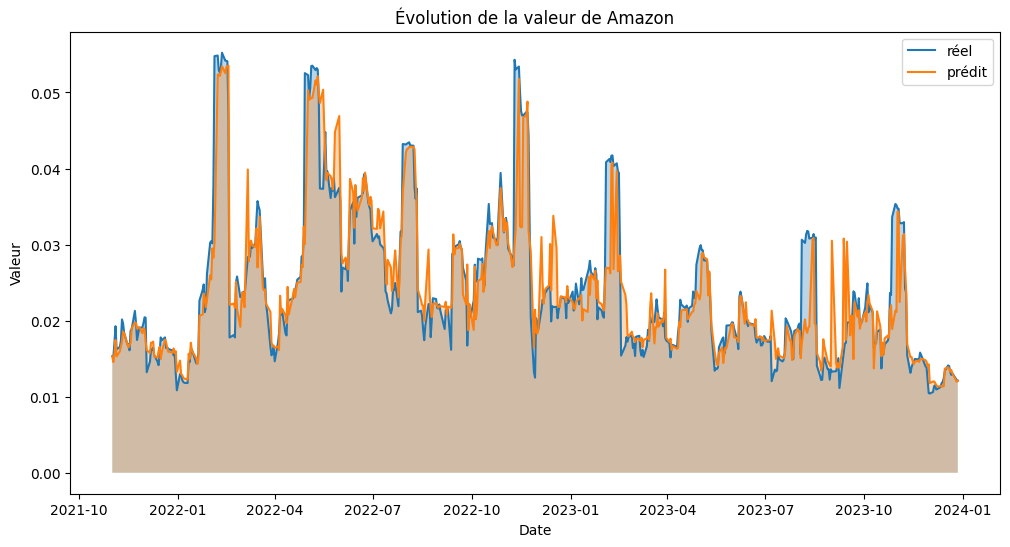

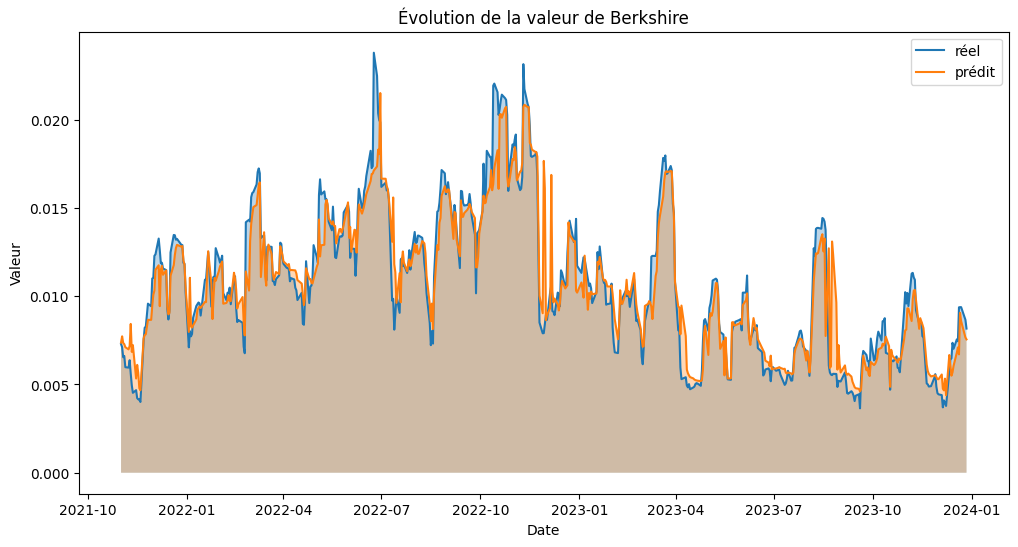

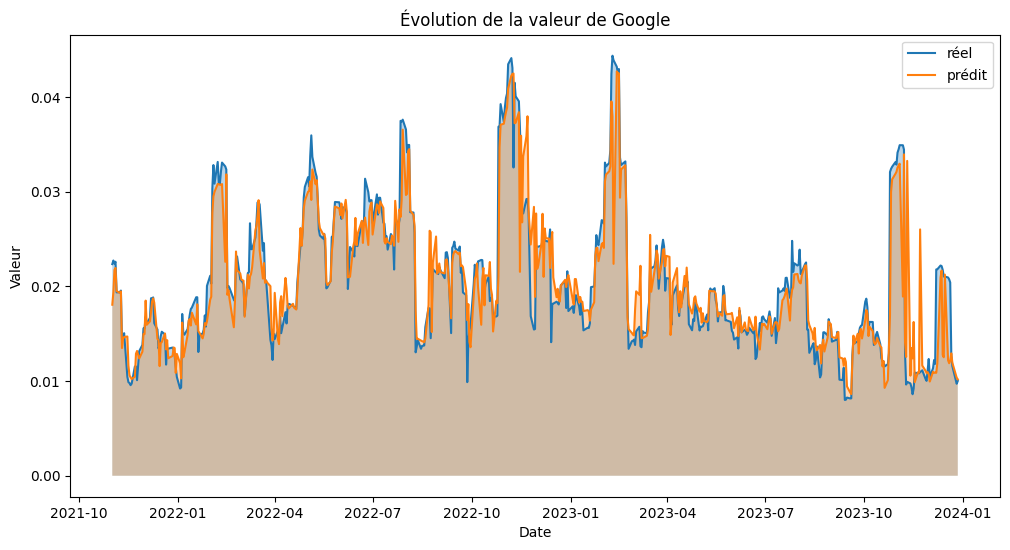

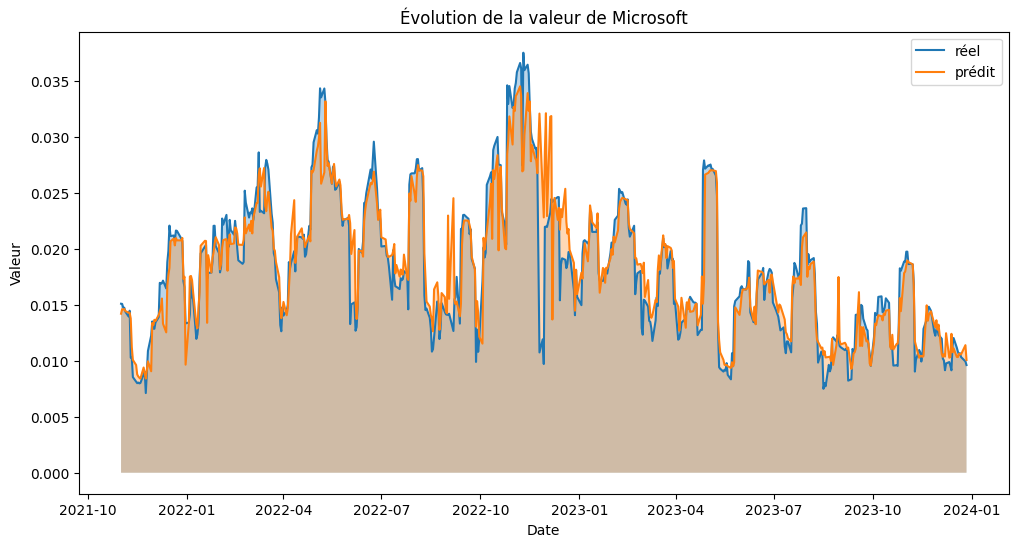

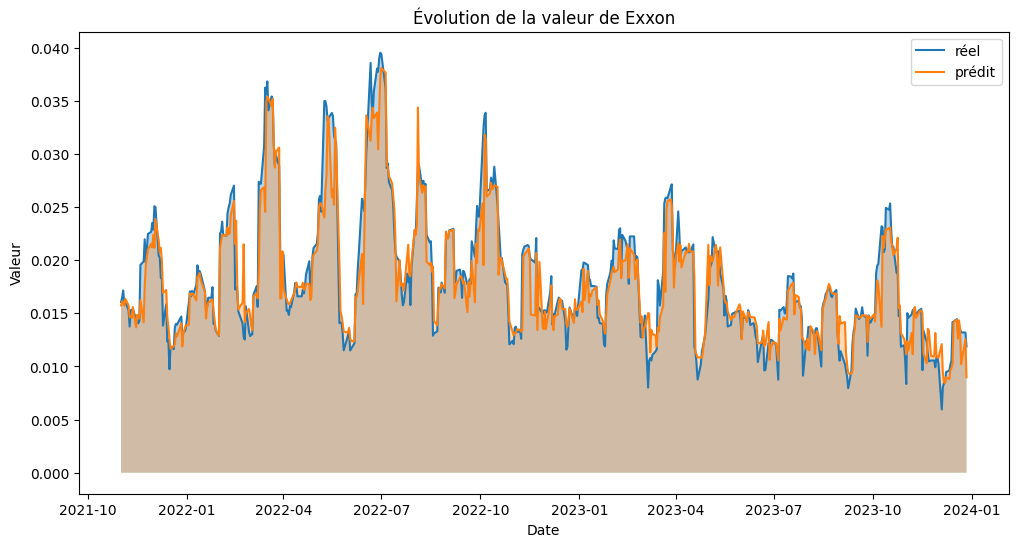

In [83]:
for key, value in predictions.items() :
    fig = plt.figure(figsize=(12, 6))
    
    plt.plot(value.Date, value['Volatility'], label='réel')
    plt.fill_between(value.Date, value['Volatility'], alpha=0.3)
    
    # Plot the 'Prediction' values
    plt.plot(value.Date, value['Prediction'], label='prédit')
    plt.fill_between(value.Date, value['Prediction'], alpha=0.3)
    
    # Set the title and axis labels
    plt.title(f"Évolution de la valeur de {key}")
    plt.xlabel('Date')
    plt.ylabel('Valeur')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()

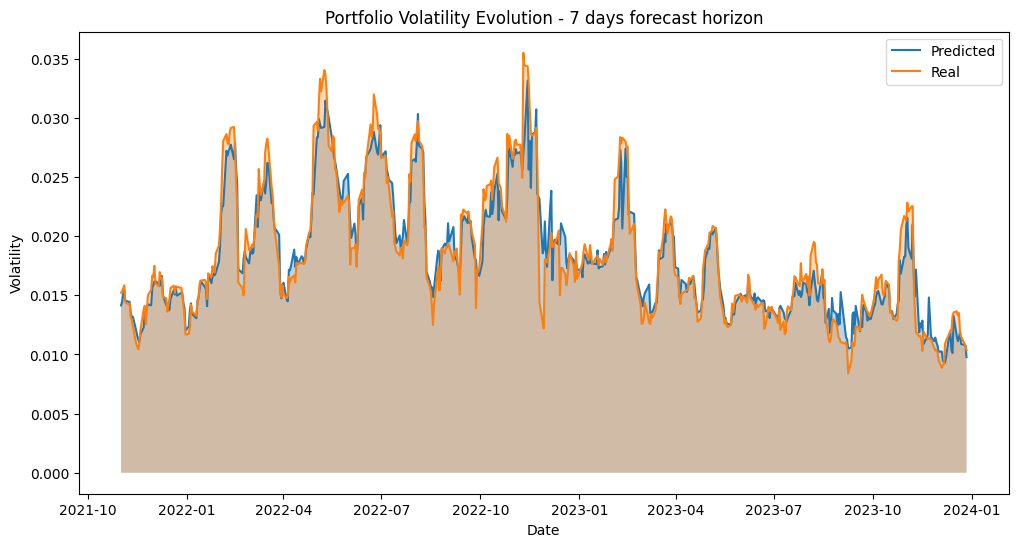

In [84]:
fig = plt.figure(figsize=(12, 6))

plt.plot(ptf_avg.Date, ptf_avg['Prediction'], label='Predicted')
plt.fill_between(ptf_avg.Date, ptf_avg['Prediction'], alpha=0.3)

plt.plot(ptf_avg.Date, ptf_avg['Volatility'], label='Real')
plt.fill_between(ptf_avg.Date, ptf_avg['Volatility'], alpha=0.3)

plt.title(f"Portfolio Volatility Evolution - 7 days forecast horizon")
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
def compute_errors(dict_df, ptf):
    resultats = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE'])

    mse_ptf = mean_squared_error(ptf["Predicted_Portfolio_Value"], ptf["Real_Portfolio_Value"])
    mae_ptf = mean_absolute_error(ptf["Predicted_Portfolio_Value"], ptf["Real_Portfolio_Value"])
    rmse_ptf = np.sqrt(mse_ptf)

    resultats.loc["Portfolio"] = [mse_ptf, rmse_ptf, mae_ptf]

    for actif, df in dict_df.items():
        mse = mean_squared_error(df['Close'], df['Prediction'])
        mae = mean_absolute_error(df['Close'], df['Prediction'])
        rmse = np.sqrt(mse)

        resultats.loc[actif] = [mse, rmse, mae]

    return resultats

In [71]:
errors = compute_errors(predictions, ptf_avg)

In [72]:
errors

,MSE,RMSE,MAE
Portfolio,7801.434817,88.325731,75.510236
Amazon,165.109151,12.849481,8.341908
Berkshire,199.647570,14.129670,9.421960
Google,34.826207,5.901373,4.482750
Microsoft,216.675108,14.719888,10.748478
Exxon,42.781537,6.540760,4.919214
